In [116]:
# TODOs 
# cost estimate (prompting):
#.   817 input tokens, 261 output. Using sonnet, that's (817*3+261*15)/(10**6) = $0.006366 = 0.6366 per image
#. 
# cost estimate (search)
#. 

# think about cost /scaling 
# pick embeddings 
# consider embedding alternatives 


from IPython import display
# from IPython.display import display
import anthropic

import json
import io
import base64
from dotenv import load_dotenv
import os
from PIL import Image
load_dotenv()

ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_API_KEY')
 

In [69]:
def pil_image_to_base64(pil_image):
    img_buffer = io.BytesIO()
    pil_image.save(img_buffer, format='PNG')
    img_bytes = img_buffer.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')
    return img_base64
 

In [70]:
SYSTEM_PROMPT = """You are a helpful bot who provides detailed tags for professioanlly done marketing emails. 
These tags will be used to help users search a database of marketing emails to discover the ones that are most relevant to their query. 
It's important that you think like a professional marketing designer when writing these tags. How would a marketer think about these issues?

For each of the following categories, please return 5-10 tags. related to themes you see in the email. 

Themes:
- layout: how are the text and images laid out?  
- brand style: what words best represent the brand voice of this email?  
- text: what kinds of fonts do they use, what text techniques do they use?
- color scheme: how would you describe the vibe of color scheme? (don't say specific colors, more general i
- other: anything else that might be relevant

Return the output as a json dictionary like so:
{
    "layout": [ ...],
    "brand_style": [...],
    "text": [...],
    "color_scheme": [...],
    "other": [...],
}
"""


CLIENT = anthropic.Anthropic()
 

In [112]:
PROJECT_BASE_PATH = os.path.join(
            os.path.expanduser("~"),"Desktop", "email_search_project")

EMAIL_IMAGES_DIR = os.path.join(PROJECT_BASE_PATH, "example_emails")
EMAIL_METADATA_DIR = os.path.join(PROJECT_BASE_PATH, "email_metadata")

def create_image_tags(image_file_name):
        
    image_path = os.path.join(EMAIL_IMAGES_DIR, image_file_name)
    image = Image.open(image_path)
    
        
    message = CLIENT.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1000,
        temperature=0,
        system=SYSTEM_PROMPT,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": pil_image_to_base64(image),
                        },
                    },
                ]
            }
        ]
    ) 
    return json.loads(message.content[0].text)
        

In [91]:
for image_file in os.listdir(EMAIL_IMAGES_DIR):
    if ".png" not in image_file:
        continue
    print(image_file)

    json_file_name = image_file.replace(".png",".json")

    if json_file_name in os.listdir(EMAIL_METADATA_DIR):
        continue

    email_tags = create_image_tags(image_file)

    print("creating file")
    with open(os.path.join(EMAIL_METADATA_DIR,json_file_name), 'w') as file:
        json.dump(email_tags, file, indent=4)
 

your-at-home-facial-tips.png
the-autumn-harvest-bowl.png
fortune-favors-the-bold-toast-to-the-new-year.png
15-off-valentines-day-gifts.png
thirsty-lets-fix-that.png
cocktails-commerce-under-the-stars-how-to-spot-consequential-ai-6-conversational-strategy-ideas.png
see-what-the-buzz-is-all-about.png
facing-the-toughest-talk-yet.png
is-cbd-for-dogs-worth-the-hype.png
the-pelago-app-just-got-a-major-upgrade.png
mythbuster-see-melatonin-in-a-new-light.png
never-miss-a-flight-deal-again.png
discover-our-newest-hospitality-furniture.png
10-off-weight-loss-meds-delivered-to-your-door.png
last-chance-to-join-canvas-24.png
your-order-is-ready-to-place.png
take-care-of-your-gut-health.png
two-thumbs-up.png
sign-up-for-our-free-marathon-training-program-today.png
check-out-these-hacks-for-more-time-in-nature.png
how-much-does-a-dental-cleaning-cost-without-insurance.png
our-2024-highlights-by-the-numbers.png
products-updates-edition-19-2024.png
gifts-for-kids.png
smiles-davis-check-out-your-2024-

In [74]:
# embeddings 

from langchain_pinecone import PineconeEmbeddings
import os

model_name = 'multilingual-e5-large'
embeddings = PineconeEmbeddings(
    model=model_name,
    pinecone_api_key=os.environ.get('PINECONE_API_KEY')
)

In [75]:
# create pinecone index


from pinecone import Pinecone, ServerlessSpec
import time

pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))



cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'
spec = ServerlessSpec(cloud=cloud, region=region)

index_name = "email-search-full"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=embeddings.dimension,
        metric="cosine",
        spec=spec
    )
    # Wait for index to be ready
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# See that it is empty
print("Index before upsert:")
print(pc.Index(index_name).describe_index_stats())
print("\n")

Index before upsert:
{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}




In [95]:
from langchain_pinecone import PineconeVectorStore

from langchain_core.documents import Document


namespace = "wondervector5000"

def email_json_to_string(email_metadata_json):
    email_tags_str = ""

    for k, v in email_metadata_json.items():
        email_tags_str = email_tags_str + "\n\n" + k + ":\n - " + "\n - ".join(v)

    return(email_tags_str)


data_to_embed_list = []
for email_metadata_file in os.listdir(EMAIL_METADATA_DIR):
    if email_metadata_file.startswith("."):
        continue

    with open(os.path.join(EMAIL_METADATA_DIR, email_metadata_file), "r") as f:
        email_metadata_json = json.load(f)

    print(email_metadata_file)
    email_tags_str = email_json_to_string(email_metadata_json)


    data_to_embed_list.append(
        {
            "id": email_metadata_file.replace(".json",""),
            "text": email_tags_str
            
        }
    )
    
  

         

up-to-40-off-your-first-trip.json
10-off-weight-loss-meds-delivered-to-your-door.json
a-wild-and-wonderful-welcome-2.json
get-paid-to-move-to-these-10-cities.json
how-much-does-a-dental-cleaning-cost-without-insurance.json
actually-the-perfect-gift.json
dont-miss-your-last-chance-to-save.json
never-miss-a-flight-deal-again.json
take-care-of-your-gut-health.json
our-social-media-trends-2025-report-is-here.json
back-in-stock-roval-rapide-cockpit.json
thirsty-lets-fix-that.json
outdoorsy-gift-cards-are-here.json
get-to-know-the-waking-up-app.json
the-autumn-harvest-bowl.json
last-chance-to-shop-our-holiday-sale.json
the-perfect-gift-for-him.json
tomato-roll-ons-for-all.json
check-out-these-hacks-for-more-time-in-nature.json
the-pelago-app-just-got-a-major-upgrade.json
is-cbd-for-dogs-worth-the-hype.json
we-made-ugly-holiday-sweaters.json
new-january-decaf-dealz.json
welcome-to-a-world-of-interesting-drinks.json
see-what-the-buzz-is-all-about.json
you-dont-want-to-be-late.json
cocktails-co

In [100]:


# Convert the text into numerical vectors that Pinecone can index
embeddings = pc.inference.embed(
    model="multilingual-e5-large",
    inputs=[d["text"] for d in data_to_embed_list],
    parameters={
        "input_type": "passage", 
        "truncate": "END"
    }
)

print(embeddings)

EmbeddingsList(
  model='multilingual-e5-large',
  vector_type='dense',
  data=[
    {'vector_type': dense, 'values': [0.01336669921875, -0.03192138671875, ..., -0.0305328369140625, -0.0166168212890625]},
    {'vector_type': dense, 'values': [0.01149749755859375, -0.0333251953125, ..., -0.01116180419921875, -0.032135009765625]},
    ... (46 more embeddings) ...,
    {'vector_type': dense, 'values': [0.0049896240234375, -0.03973388671875, ..., -0.0250091552734375, -0.0186767578125]},
    {'vector_type': dense, 'values': [0.008758544921875, -0.041656494140625, ..., -0.0264739990234375, -0.0185394287109375]}
  ],
  usage={'total_tokens': 10562}
)


In [98]:
 
index_name = 'email-search-full'
index = pc.Index(index_name)

records = []
for d, e in zip(data_to_embed_list, embeddings):
    records.append({
        "id": d["id"],
        "values": e["values"], 
    })

# Upsert the records into the index
index.upsert(
    vectors=records,
    namespace="email-search-full"
)
 

{'upserted_count': 50}

In [120]:
def get_email_tags_str(email_name):
    
    with open(os.path.join(EMAIL_METADATA_DIR, email_name + ".json"), "r") as f:
        email_metadata_json = json.load(f)
    
    return email_json_to_string(email_metadata_json) 


def get_email_image_path(email_name):
    return os.path.join(EMAIL_IMAGES_DIR, email_name + ".png") 

def search_email(email_name):
    email_tags_str = get_email_tags_str(email_name)

    query_embedding = pc.inference.embed(
        model="multilingual-e5-large",
        inputs=[email_tags_str],
        parameters={
            "input_type": "query"
        }
    )

    results = index.query(
        namespace="email-search-full",
        vector=query_embedding[0].values,
        top_k=4,
        include_values=False,
        include_metadata=False
    )
  
    most_similar_emails_paths = []
    for m in results['matches']:
        if m['id'] != email_name:
            most_similar_emails_paths.append(get_email_image_path(m['id']))


    return get_email_image_path(email_name), most_similar_emails_paths
 
            

my_email, most_similar_emails_paths = search_email("hi-were-bobbie") 


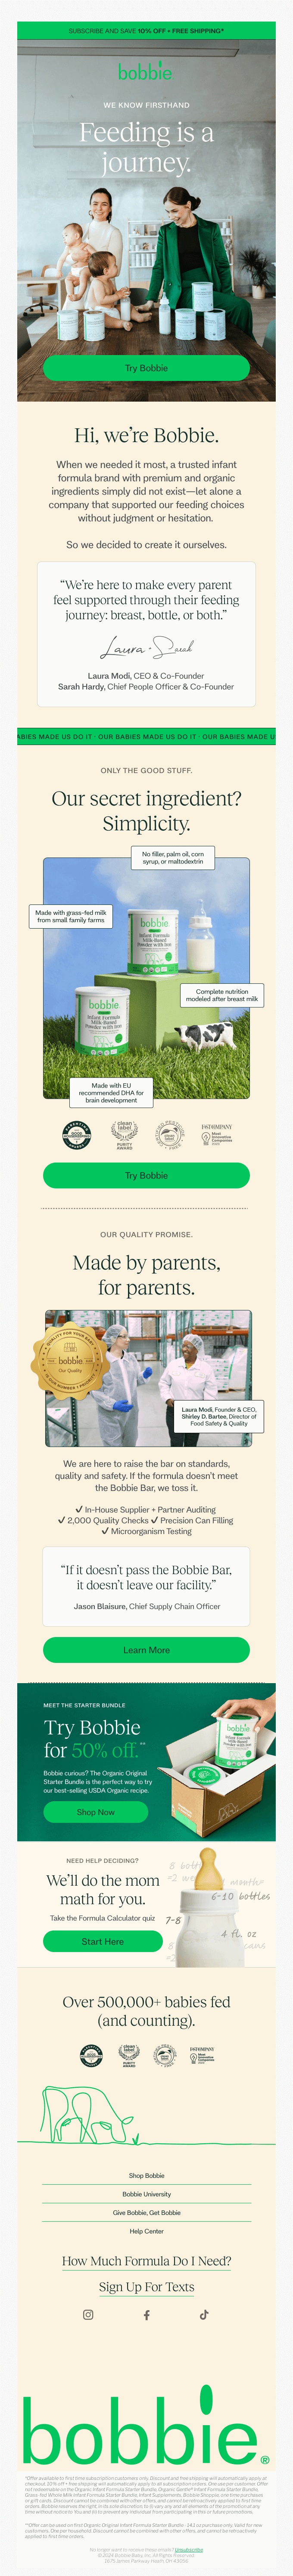
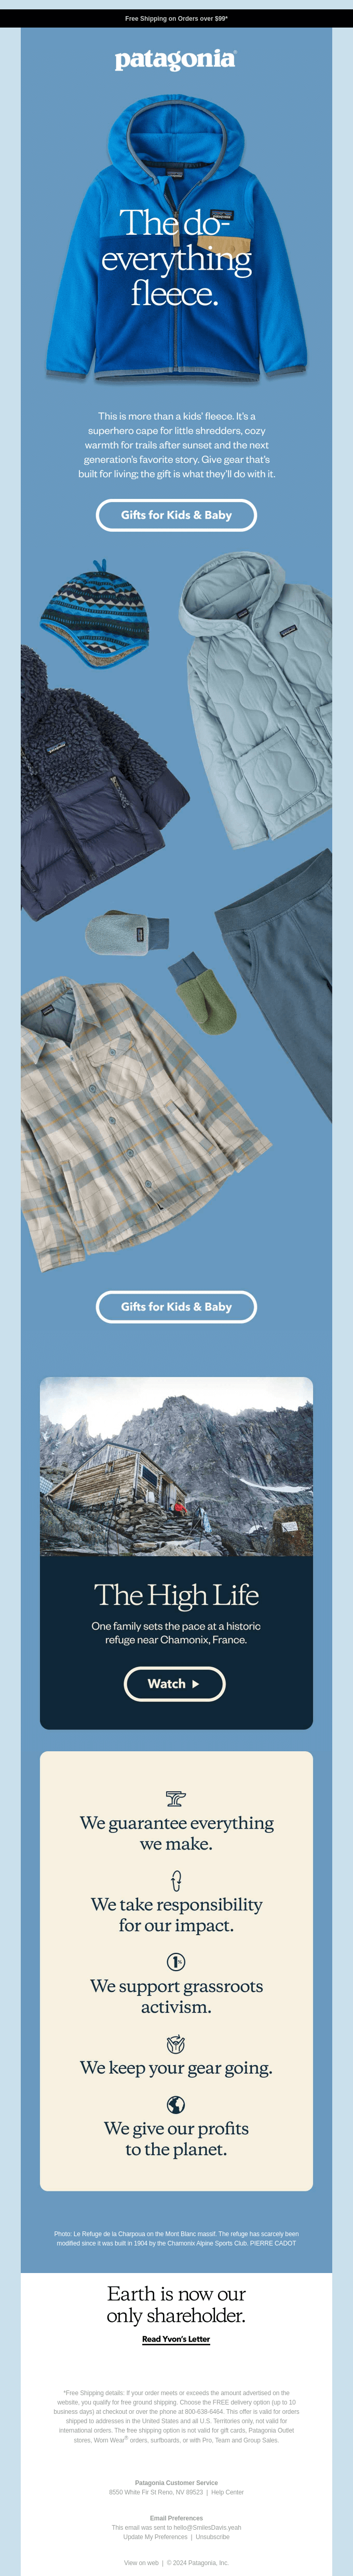
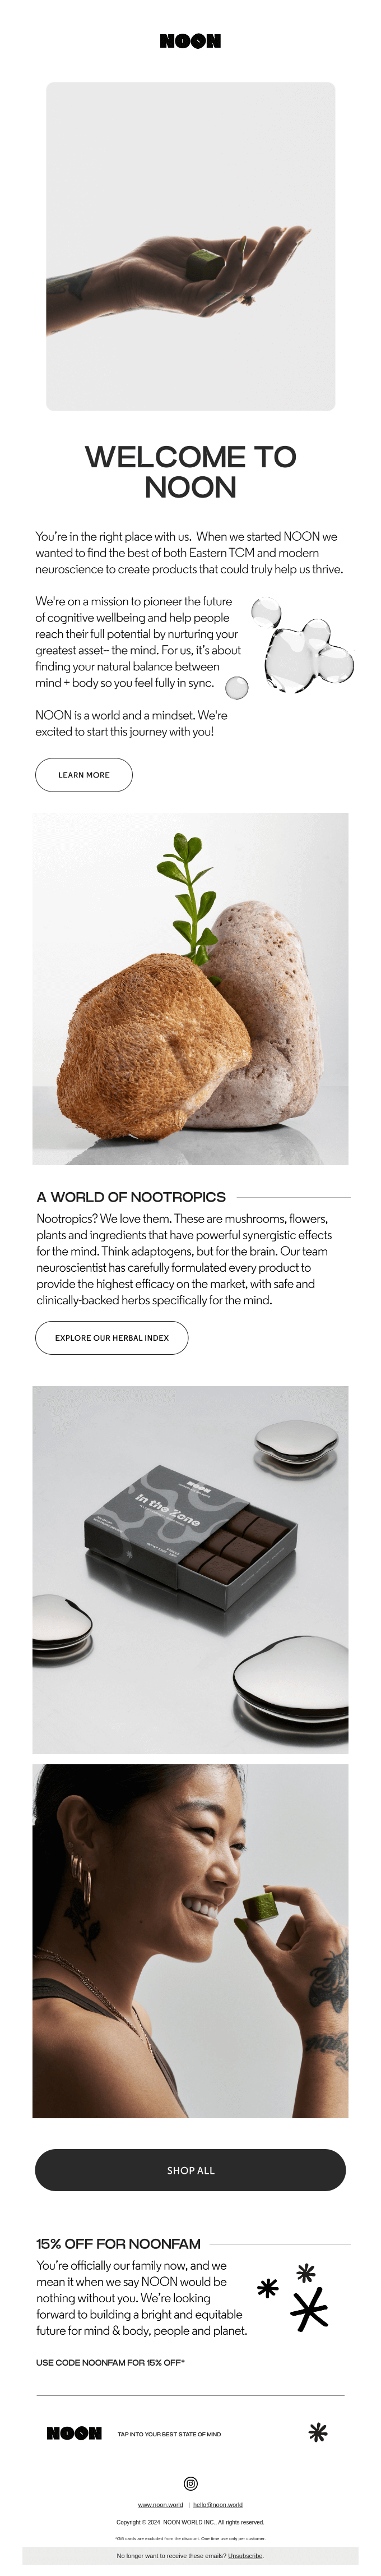
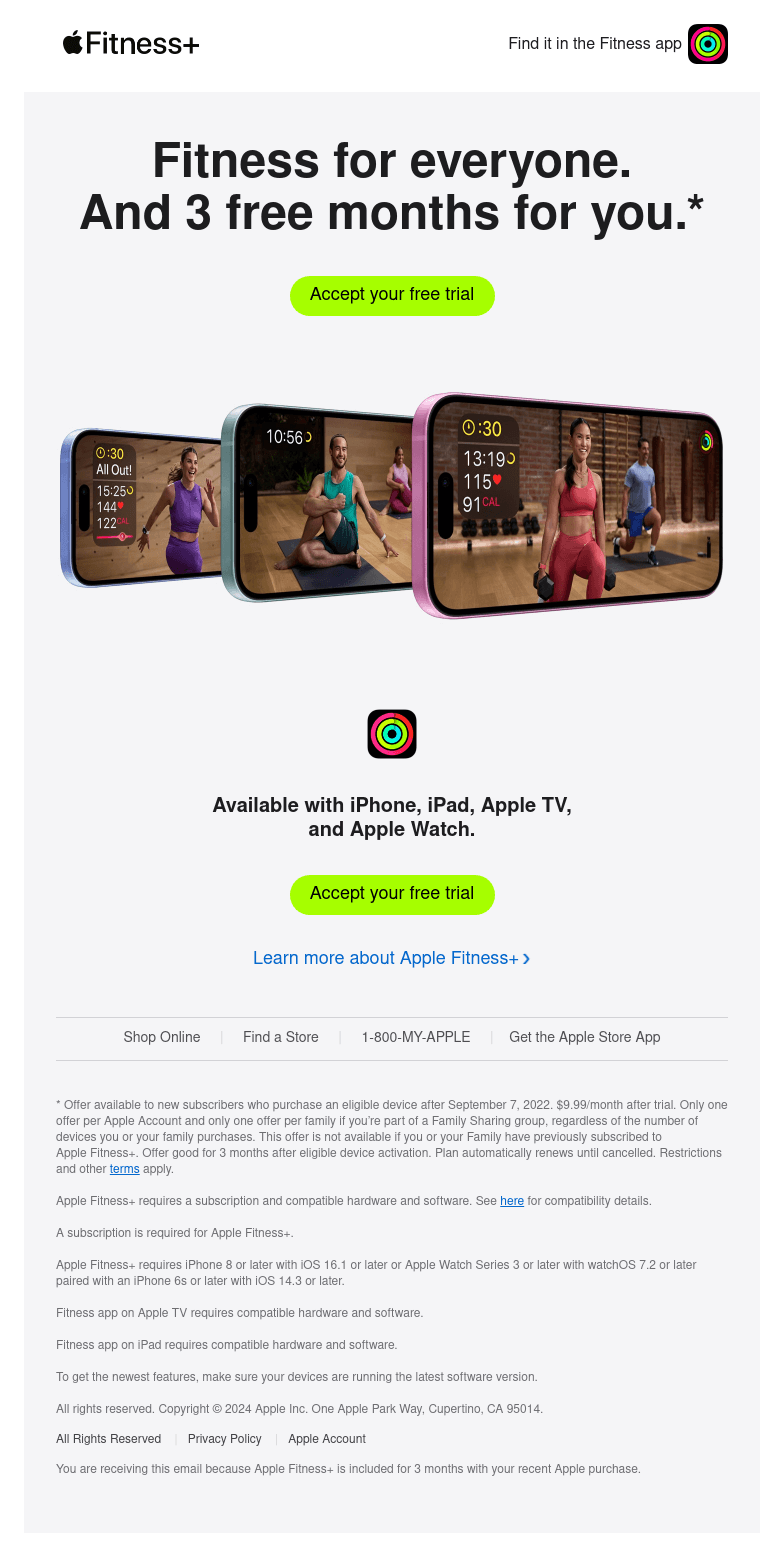

In [157]:

def show_emails(my_email, most_similar_emails_paths):
    def get_image_base64(image_path):
        with open(image_path, 'rb') as img_file:
            return base64.b64encode(img_file.read()).decode('utf-8')
     
     
    
    html_content = f"""
    <div class="row" style="display: flex; justify-content: space-between;align-items: flex-start;">   
        <div style="display: flex; flex-direction: column; align-items: center; width: 25%;">
        
            <h2>Reference email</h2>
            <img src="data:image/jpeg;base64,{get_image_base64(my_email)}" style="width:90%;object-fit: contain;">
        </div>  
        <div style="display: flex; flex-direction: column; align-items: center; width: 75%;">      
            <h2>Most similar emails</h2>
            <div class="row" style="display: flex; justify-content: space-between; width: 75%;align-items: flex-start;"> 
        
            {''.join(f""" 
            
                <img src="data:image/jpeg;base64,{get_image_base64(path)}" style="width:30%;object-fit: contain;">
                
                """ for path in most_similar_emails_paths)
                }
            </div>
        </div>
    </div>
    """ 
    
    display.display(display.HTML(html_content))

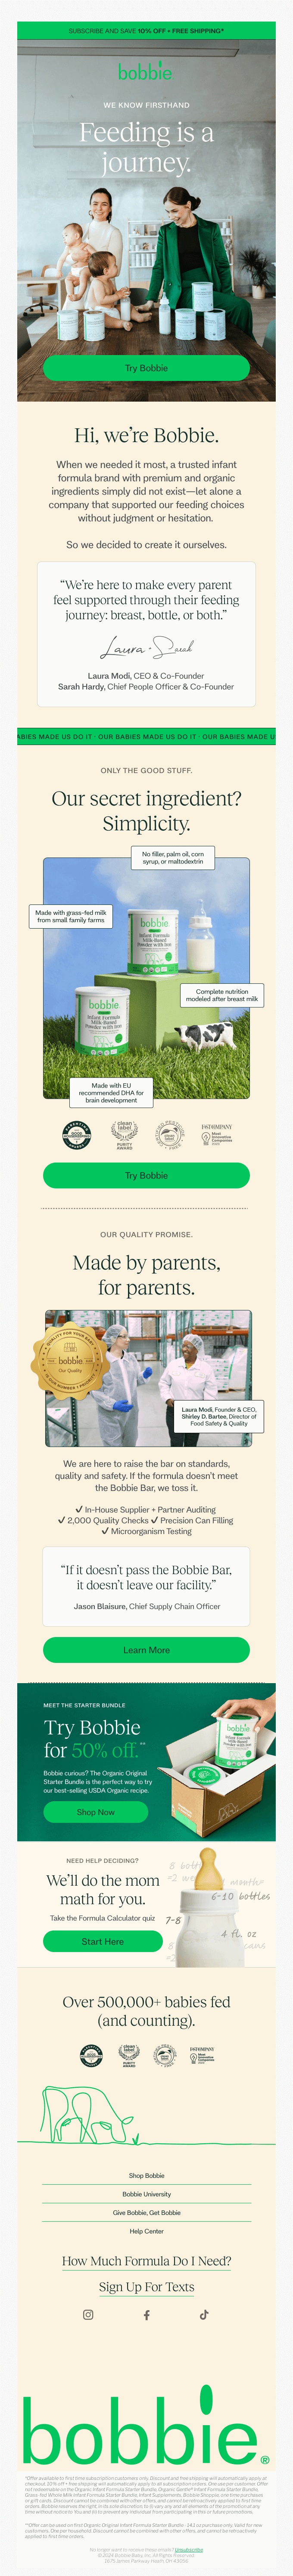

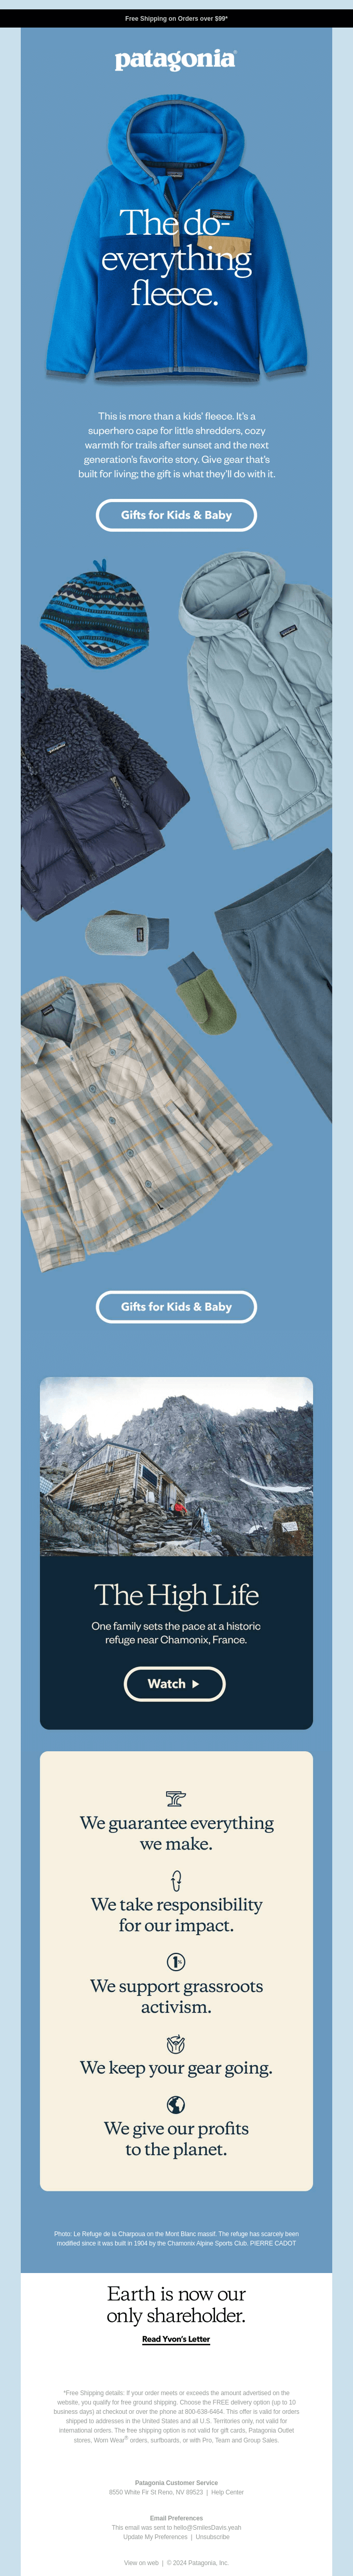

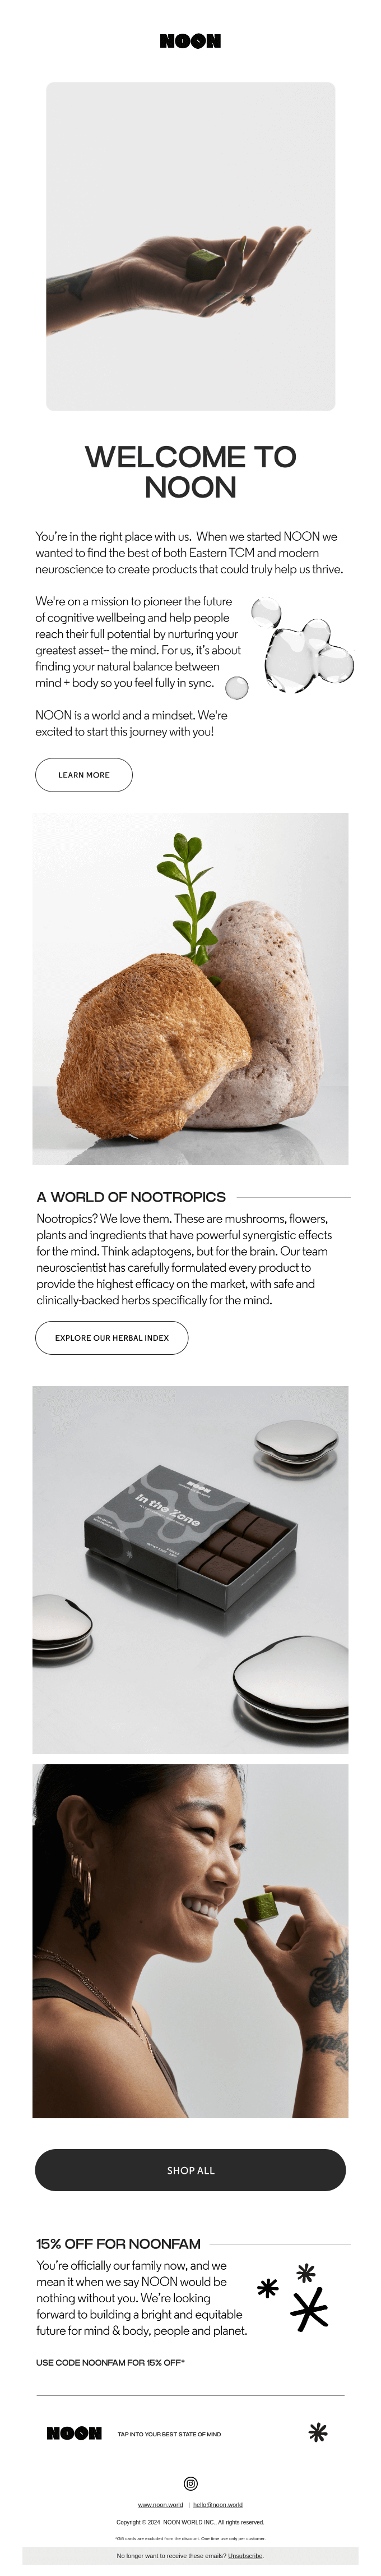

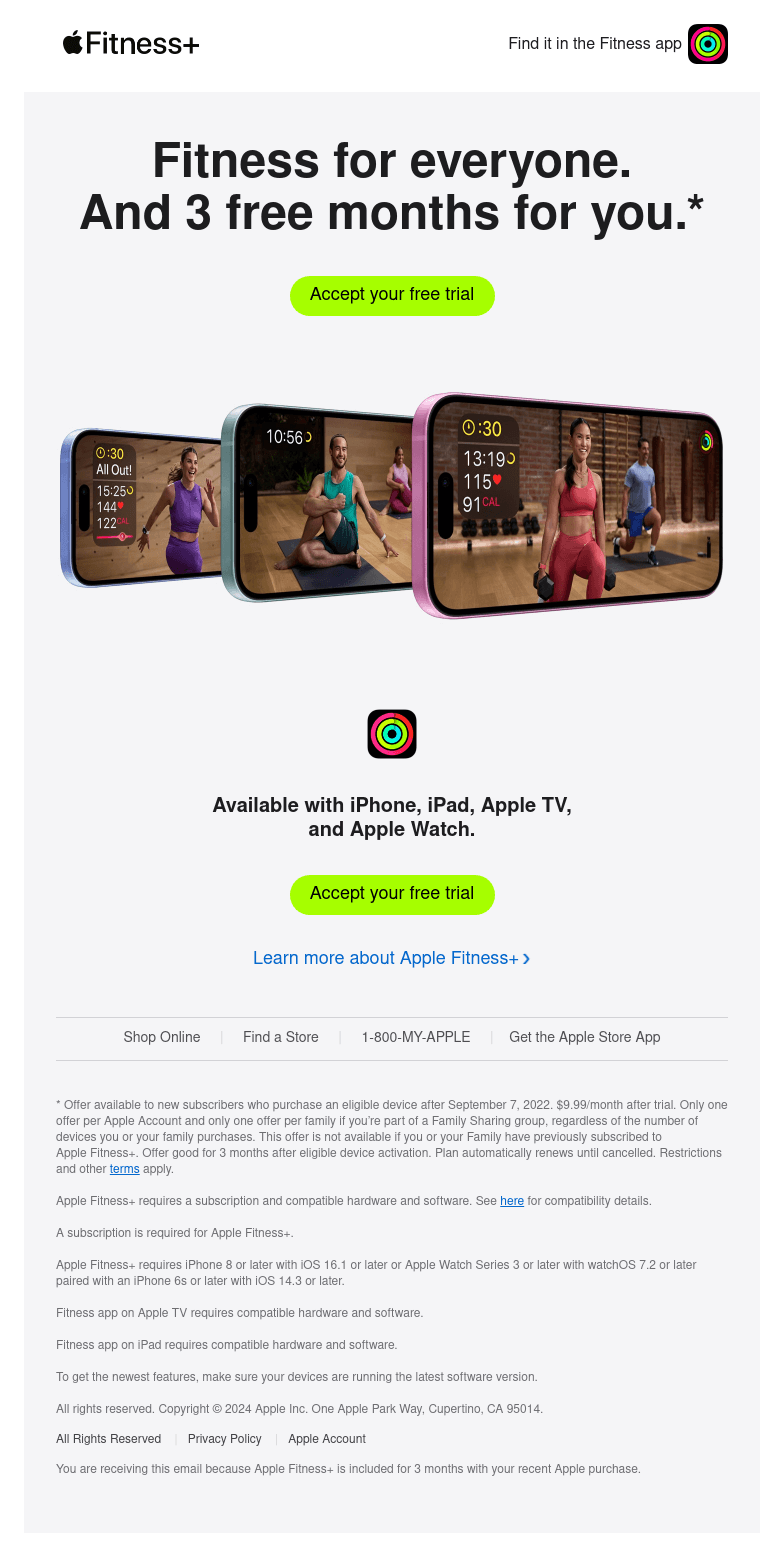

In [126]:

display.display(display.Image(my_email, width=200), 
        display.Image(most_similar_emails_paths[0], width=200),
        display.Image(most_similar_emails_paths[1], width=200),
        display.Image(most_similar_emails_paths[2], width=200))